# Convolutional Neural Network on Fashion MNIST
---
Don't forget to use **https://pytorch.org/docs/stable/**

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Intro to convolutional filters over image

In [13]:
from image_processing_workshop.utils import get_image_from_url
from image_processing_workshop.visual import plot_image
import matplotlib.pylab as plt
import numpy as np
import torch

### Download your favouirite image

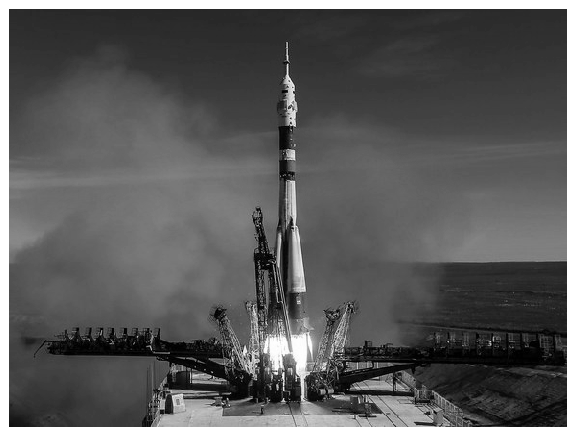

In [21]:
url = 'https://media.wired.com/photos/5bbf72c46278de2d2123485b/master/w_582,c_limit/soyuz-1051882240.jpg'
img = get_image_from_url(url, to_grayscale=True)
plot_image(img, is_grayscale=True)

### Explore prepared filters

In [22]:
initial_filter = np.array([[-1, -1, 1, 1], 
                           [-1, -1, 1, 1], 
                           [-1, -1, 1, 1], 
                           [-1, -1, 1, 1]])
filter_1 = initial_filter
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

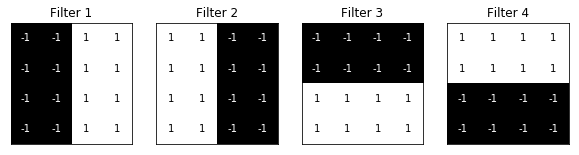

In [23]:
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))
    width, height = filters[i].shape
    
    # Add -1 1 annotations to image.
    for x in range(width):
        for y in range(height):
            ax.annotate(str(filters[i][x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if filters[i][x][y]<0 else 'black')

### Build small network initialised with those filters
In the examples, we will use `torch.nn.conv2d` https://pytorch.org/docs/stable/nn.html#conv2d

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [25]:
filters_torch = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
filters_torch.shape

torch.Size([4, 1, 4, 4])

In [26]:
img_torch = torch.from_numpy(img).unsqueeze(0).unsqueeze(1)
img_torch.shape

torch.Size([1, 1, 436, 582])

In [28]:
class ConvNeuralNetSimple(nn.Module):    
    def __init__(self, filters):
        super(ConvNeuralNetSimple, self).__init__()
        
        height, width = filters.shape[2:]
        self.conv_layer = nn.Conv2d(1, 4, kernel_size=(height, width), bias=False)
        self.conv_layer.weight.data = filters

    def forward(self, images):
        return self.conv_layer(images)
    
conv_neural_net_simple = ConvNeuralNetSimple(filters_torch)
print(conv_neural_net_simple)
print(list(conv_neural_net_simple.parameters()))

ConvNeuralNet(
  (conv_layer): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
[Parameter containing:
tensor([[[[-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.]]],


        [[[ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.]]],


        [[[-1., -1., -1., -1.],
          [-1., -1., -1., -1.],
          [ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.]]],


        [[[ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.],
          [-1., -1., -1., -1.],
          [-1., -1., -1., -1.]]]], requires_grad=True)]


Convoluton filters efectively change height and width of input image that

$H_{out} = \lfloor \frac{H_{in}+2×padding[0]−dilation[0]×(kernel\_size[0]−1)−1}{stride[0]} +1 \rfloor$   
$W_{out} = \lfloor \frac{W_{in}+2×padding[1]−dilation[1]×(kernel\_size[1]−1)−1}{stride[1]} +1 \rfloor$



In [ ]:
img_torch.shape

In [ ]:
feature_maps = conv_neural_net_simple(img_torch)
feature_maps.shape

### Visualize conv layer fature maps

In [19]:
def vizualize_feature_maps(feature_maps, n_maps= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_maps):
        ax = fig.add_subplot(1, n_maps, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(feature_maps[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

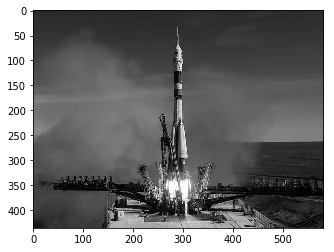

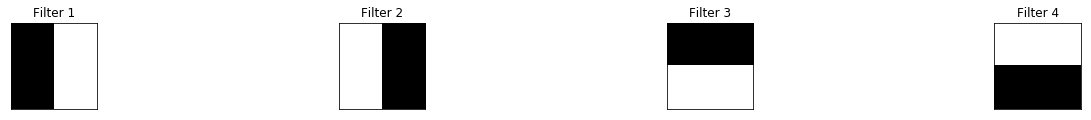

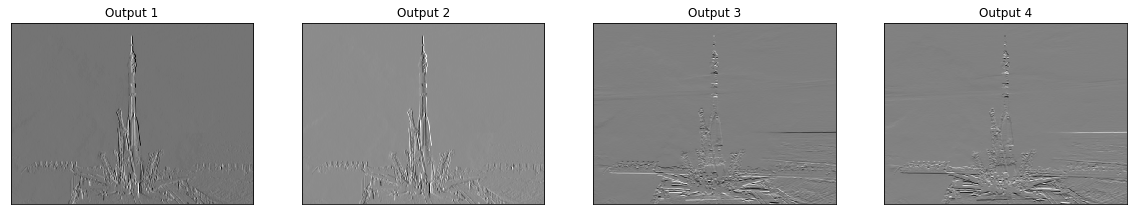

In [29]:
# Source img.
plt.imshow(img, cmap='gray')

# Convolution filters.
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

# Feature maps.    
vizualize_feature_maps(feature_maps)

### Sensitivity of image on convolution filters

In [30]:
from ipywidgets import interactive
import ipywidgets as ipw

In [44]:
feature_map = feature_maps[0][0].detach().numpy()
feature_map.shape

(433, 579)

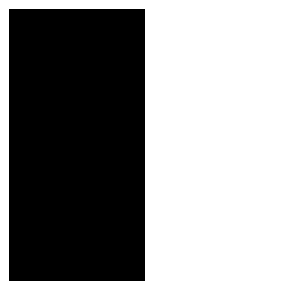

In [52]:
plot_image(filter_1, is_grayscale=True, figsize=(5, 5))

In [43]:
feature_map_max = feature_map.max()
def plot_sensitivity(tolerance):
    feature_map_filtered = (feature_map >= (feature_map_max - tolerance)).astype(int)
    fig = plt.figure(figsize=(10, 10))
    im = plt.imshow(feature_map_filtered, cmap='gray')
    plt.colorbar(im, orientation='horizontal')
    plt.gca().axes.set_axis_off()
    plt.show()
    
interactive(plot_sensitivity, tolerance=ipw.FloatSlider(0.5, min=0, max=feature_map_max - 0.1, step=0.01))

interactive(children=(FloatSlider(value=0.5, description='tolerance', max=5.456862354278565, step=0.01), Outpu…

## Building Model

In [5]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Compose
from torch.utils.data import DataLoader

### Prepare Fashion MNIST dataset

In [6]:
transformations = Compose([ToTensor()])
train_dataset = FashionMNIST('fm_data/', download=True, train=True, transform=transformations, target_transform=None)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = FashionMNIST('fm_data/', download=True, train=False, transform=transformations, target_transform=None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
test_dataset[0][0].shape

torch.Size([1, 28, 28])

### Define neural network

In [76]:
from torch.nn import Module, Sequential
from torch.nn import ReLU, Tanh, Dropout, Softmax, Linear, Conv2d, MaxPool2d, BatchNorm2d
from torch.nn import MSELoss, CrossEntropyLoss, NLLLoss
from torch.optim import Adam, SGD
from torch.nn.init import xavier_uniform_, normal_

In [94]:
class ConvNeuralNet(nn.Module):

    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        
        self.shape_conv1 = None
        self.conv1 = nn.Sequential(
            Conv2d(1, 32, (3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d((2, 2), stride=(2, 2)))
        
        self.shape_conv2 = None
        self.conv2 = nn.Sequential(
            Conv2d(32, 64, (3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(64),
            ReLU(),
            MaxPool2d((2, 2), stride=(2, 2)))
        
        self.linear = Linear(7*7*64, 10)

    def forward(self, images):
        x = self.conv1(images)
        self.shape_conv1 = x.shape
        
        x = self.conv2(x)
        self.shape_conv2 = x.shape

        x = x.view(x.size(0), -1)
        x = self.linear(x)
        #return torch.softmax(x, dim=1)
        return torch.log_softmax(x, dim=1)    

conv_neural_net = ConvNeuralNet()
print(conv_neural_net)

ConvNeuralNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=3136, out_features=10, bias=True)
)


In [95]:
test_dataset[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [96]:
conv_neural_net(test_dataset[0][0].unsqueeze(0))

tensor([[-2.6824, -2.6868, -1.9562, -2.1360, -2.2864, -2.1648, -2.3870, -1.9719,
         -2.9774, -2.2485]], grad_fn=<LogSoftmaxBackward>)

In [97]:
conv_neural_net.shape_conv1, conv_neural_net.shape_conv2

(torch.Size([1, 32, 14, 14]), torch.Size([1, 64, 7, 7]))

### Define optimizers and loss function

In [98]:
#loss_fce = CrossEntropyLoss()
loss_fce = NLLLoss()
loss_fce

NLLLoss()

In [99]:
optimizer = Adam(conv_neural_net.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

### Train neural net

In [100]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

In [101]:
def get_test_acc_and_loss(conv_neural_net, loss_fce, test_loader):
    accuracy = 0
    loss = 0
    
    conv_neural_net.eval()
    for images, labels in test_loader:
        predictions = conv_neural_net(images)
        accuracy += (predictions.argmax(dim=1) == labels).type(torch.FloatTensor).mean().item() 
        loss += loss_fce(predictions, labels).item()
        
    return accuracy / len(test_loader) * 100, loss / len(test_loader)

In [102]:
get_test_acc_and_loss(conv_neural_net, loss_fce, test_loader)

(8.807722929936306, 2.3040419642333014)

In [103]:
# Initial params setup.
epochs = 2
batch_iteration = 0
report_period = 100

# Storing of some data.
train_leak_loss = deque(maxlen=report_period)
train_loss_history = []
test_loss_history = []
test_acc_history = []

In [104]:
for epoch in range(epochs):
    
    # Setup net to train mode and go through one epoch.
    conv_neural_net.train()
    for images, labels in train_loader:
        batch_iteration += 1
        
        # Training net on one batch.
        optimizer.zero_grad()
        predictions = conv_neural_net.forward(images)
        loss = loss_fce(predictions, labels)
        loss.backward()
        optimizer.step()
        
        train_leak_loss.append(loss.item())
        
        # In case we should report, lets make validation on test set.
        if batch_iteration % report_period == 0:
            conv_neural_net.eval()
            # We don't want to collect info for gradients from here.
            with torch.no_grad():
                test_accuracy, test_loss = get_test_acc_and_loss(conv_neural_net, loss_fce, test_loader)
                
            print(f'Epoch: {epoch+1}/{epochs}.. ',
                  f"Train Loss: {round(np.mean(train_leak_loss), 2)}.. ",
                  f"Test Loss: {round(test_loss, 2)}.. ",
                  f"Test Acc: {round(test_accuracy, 2)}%")
            
            train_loss_history.append(np.mean(train_leak_loss))
            test_loss_history.append(test_loss)
            test_acc_history.append(test_accuracy)
                        
            conv_neural_net.train()

Epoch: 1/2..  Train Loss: 0.66..  Test Loss: 0.45..  Test Acc: 83.64%
Epoch: 1/2..  Train Loss: 0.41..  Test Loss: 0.41..  Test Acc: 85.55%
Epoch: 1/2..  Train Loss: 0.35..  Test Loss: 0.38..  Test Acc: 85.9%
Epoch: 1/2..  Train Loss: 0.35..  Test Loss: 0.35..  Test Acc: 87.73%
Epoch: 1/2..  Train Loss: 0.35..  Test Loss: 0.35..  Test Acc: 87.47%
Epoch: 1/2..  Train Loss: 0.33..  Test Loss: 0.32..  Test Acc: 88.62%
Epoch: 1/2..  Train Loss: 0.32..  Test Loss: 0.33..  Test Acc: 87.69%
Epoch: 1/2..  Train Loss: 0.34..  Test Loss: 0.36..  Test Acc: 86.92%
Epoch: 1/2..  Train Loss: 0.29..  Test Loss: 0.33..  Test Acc: 88.1%
Epoch: 2/2..  Train Loss: 0.29..  Test Loss: 0.32..  Test Acc: 88.57%
Epoch: 2/2..  Train Loss: 0.27..  Test Loss: 0.3..  Test Acc: 89.24%
Epoch: 2/2..  Train Loss: 0.26..  Test Loss: 0.32..  Test Acc: 88.59%
Epoch: 2/2..  Train Loss: 0.27..  Test Loss: 0.32..  Test Acc: 88.39%
Epoch: 2/2..  Train Loss: 0.27..  Test Loss: 0.3..  Test Acc: 89.39%
Epoch: 2/2..  Train Loss

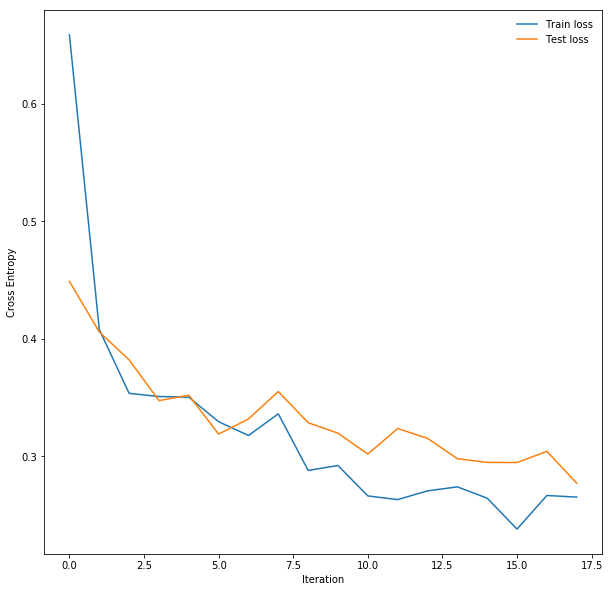

In [105]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Cross Entropy')
plt.plot(train_loss_history, label='Train loss')
plt.plot(test_loss_history, label='Test loss')
plt.legend(frameon=False)

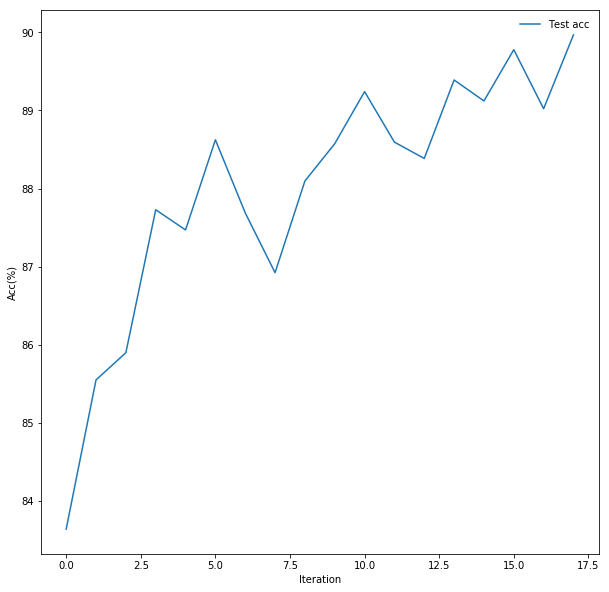

In [106]:
fig = plt.figure(figsize=(10, 10))
plt.plot(test_acc_history, label='Test acc')
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Acc(%)')
plt.legend(frameon=False)

## Results evaluation

In [107]:
conv_neural_net.eval()

ConvNeuralNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=3136, out_features=10, bias=True)
)

### View single images and predictions

In [113]:
from image_processing_workshop.visual import plot_classify, plot_image

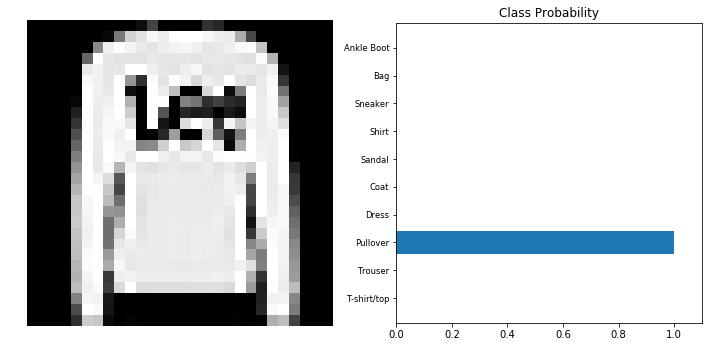

In [114]:
plot_classify(test_dataset[1][0], conv_neural_net, exp=True)

### Load reuslts to pandas df

In [119]:
from image_processing_workshop.eval import get_results_df
from image_processing_workshop.visual import plot_df_examples

In [120]:
df = get_results_df(conv_neural_net, test_loader, exp=True)
df.head(10)

,label_class_name,label_class_score,predicted_class_name_top1,predicted_class_score_top1,image
0,Ankle boot,0.999389,Ankle boot,0.999389,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,Pullover,0.999764,Pullover,0.999764,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,Trouser,0.999995,Trouser,0.999995,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00..."
3,Trouser,0.999990,Trouser,0.999990,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Shirt,0.862262,Shirt,0.862262,"[[0.0, 0.0, 0.0, 0.007843137718737125, 0.0, 0...."
5,Trouser,0.999923,Trouser,0.999923,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,Coat,0.956650,Coat,0.956650,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00..."
7,Shirt,0.935656,Shirt,0.935656,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00..."
8,Sandal,0.996746,Sandal,0.996746,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,Sneaker,0.999608,Sneaker,0.999608,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


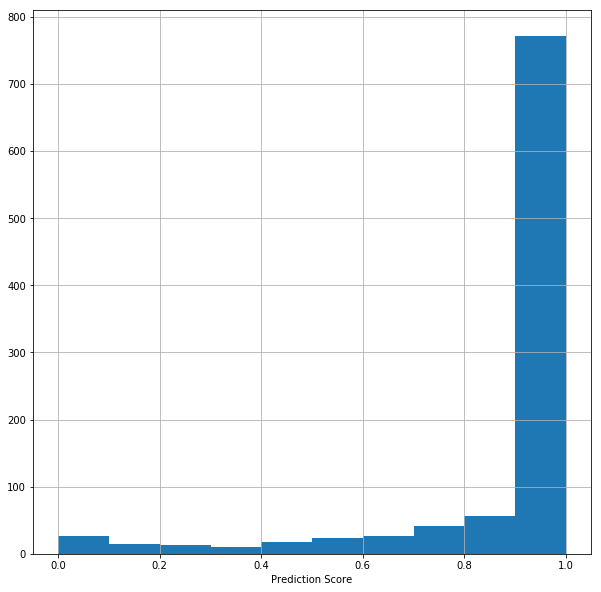

In [121]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Prediction Score')
df[df.label_class_name=='Dress'].label_class_score.hist(ax=ax)

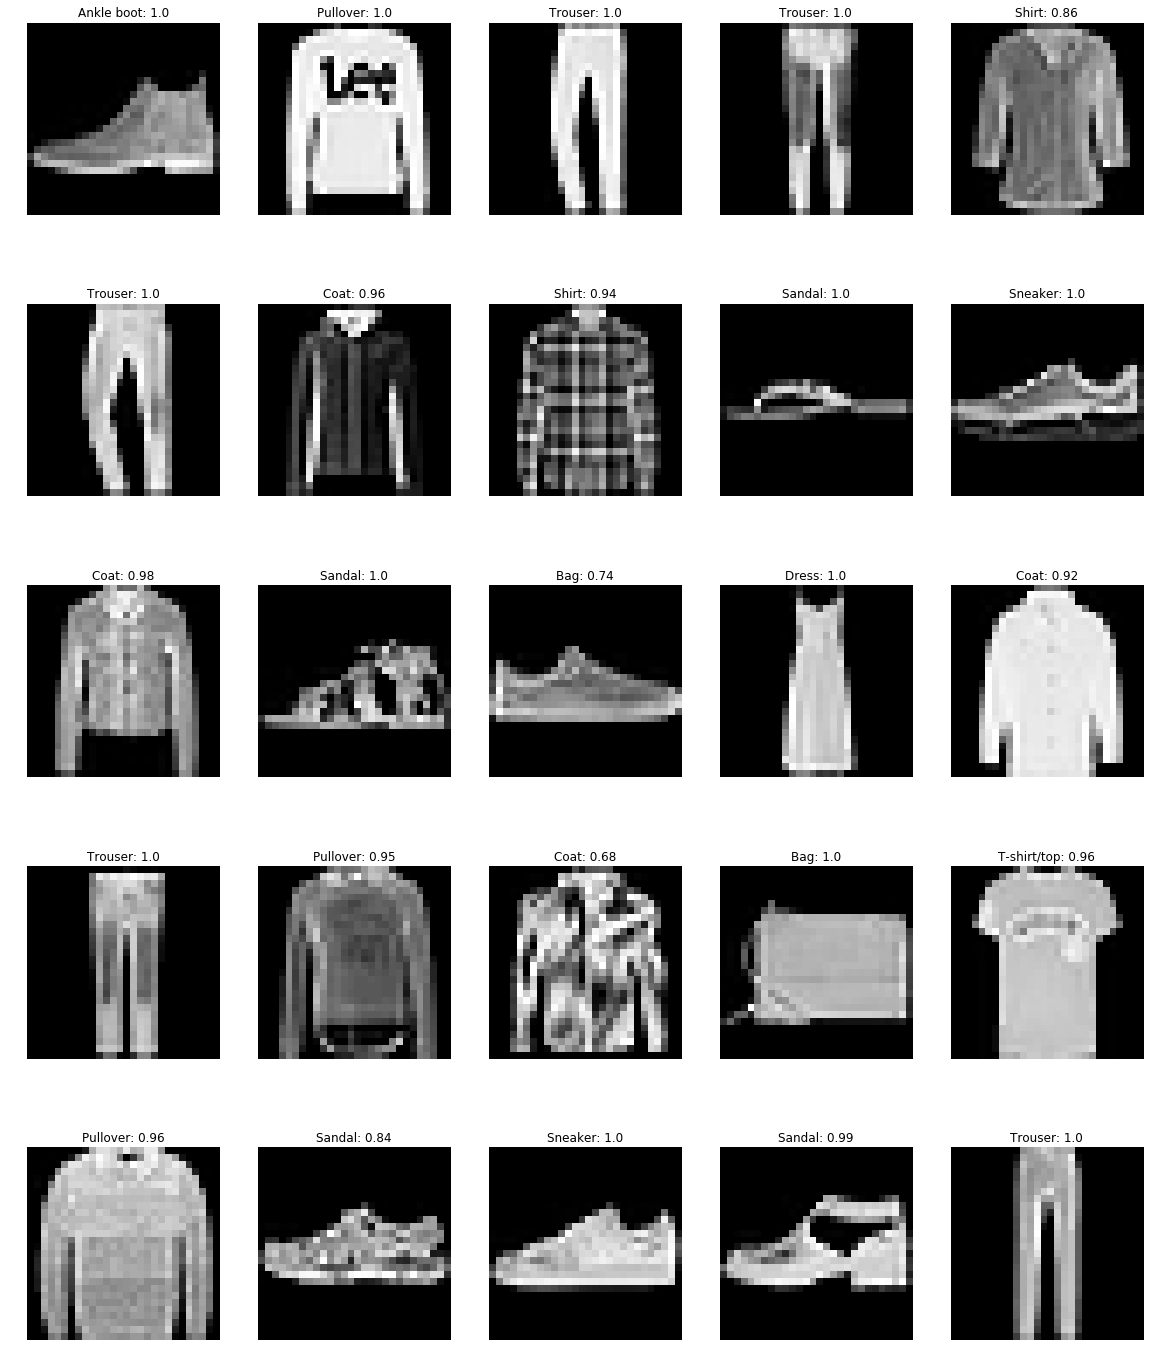

In [122]:
plot_df_examples(df.iloc[:25])

### Precision

In [123]:
from image_processing_workshop.eval import get_precision

In [124]:
get_precision(df, 'Dress')

86.69

### Recall

In [125]:
from image_processing_workshop.eval import get_recall

In [126]:
get_recall(df, 'Dress')

93.1

### Overall Recall and Precision


In [127]:
from image_processing_workshop.eval import get_rec_prec

In [128]:
get_rec_prec(df)

,class_name,recall,precision
0,T-shirt/top,84.9,87.26
1,Trouser,98.0,99.09
2,Pullover,88.3,80.64
3,Dress,93.1,86.69
4,Coat,86.0,82.30
5,Sandal,98.6,97.91
6,Shirt,63.8,80.76
7,Sneaker,93.1,96.78
8,Bag,98.7,95.73
9,Ankle boot,97.5,94.29


### Accuracy

In [129]:
from image_processing_workshop.eval import get_accuracy

In [130]:
get_accuracy(df)

90.2

### False Positives


In [131]:
from image_processing_workshop.eval import get_false_positives

In [132]:
fp = get_false_positives(df, label_class_name='Shirt')

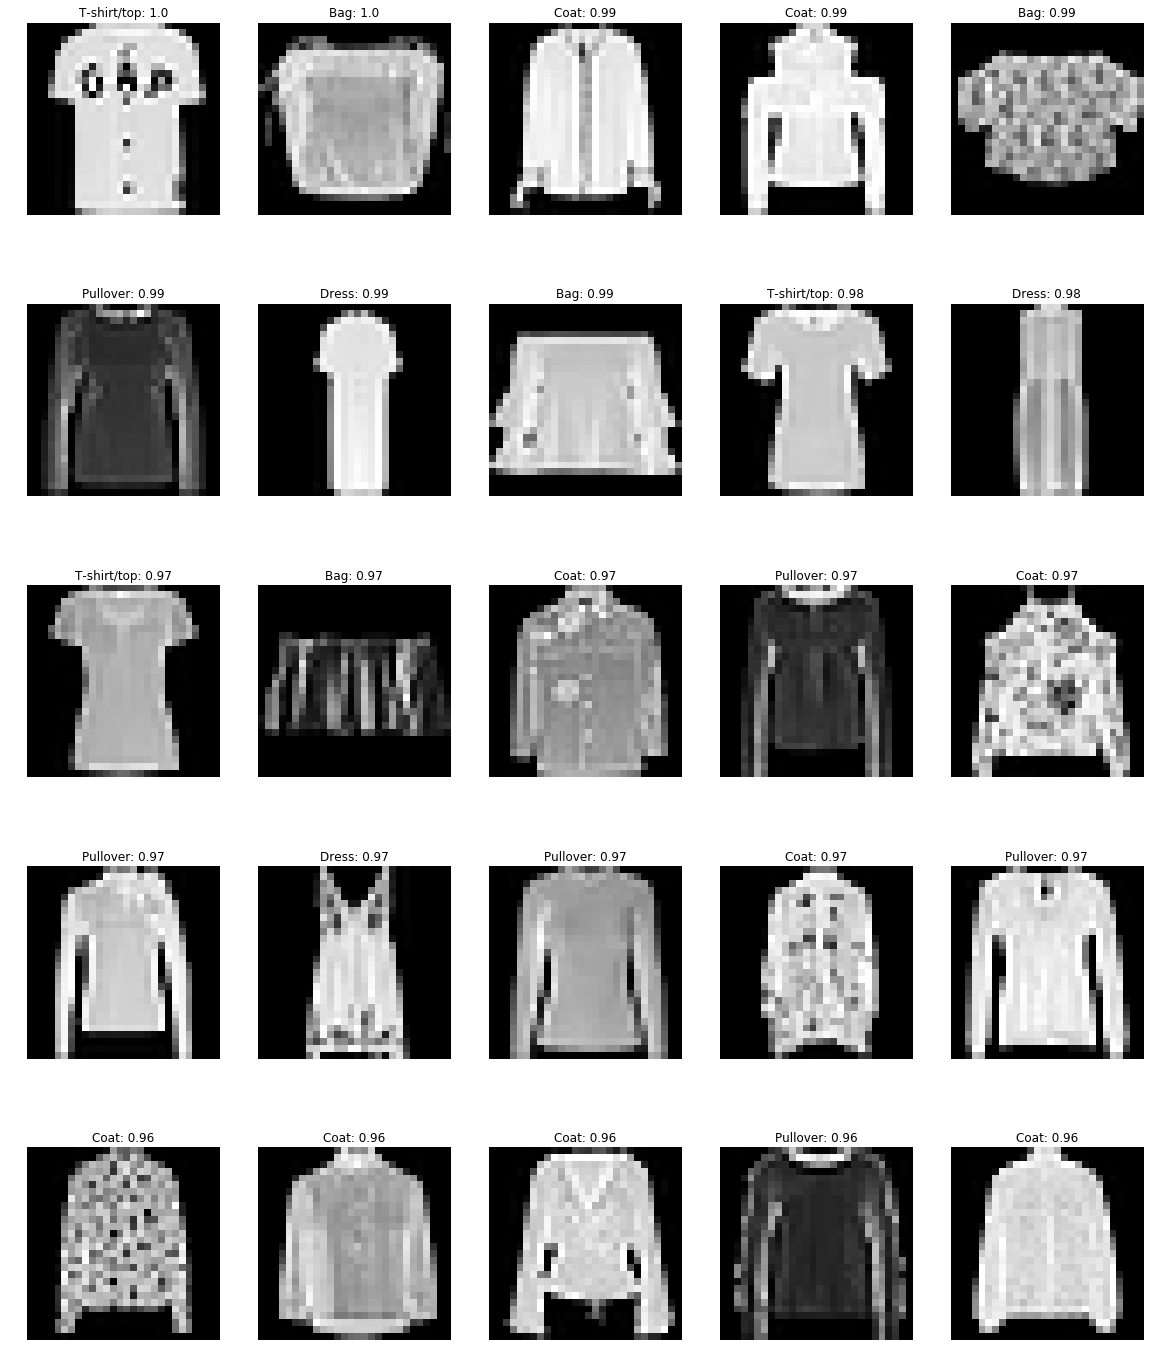

In [133]:
plot_df_examples(fp)

In [134]:
fp = get_false_positives(df, label_class_name='Shirt', predicted_class_name='Pullover')

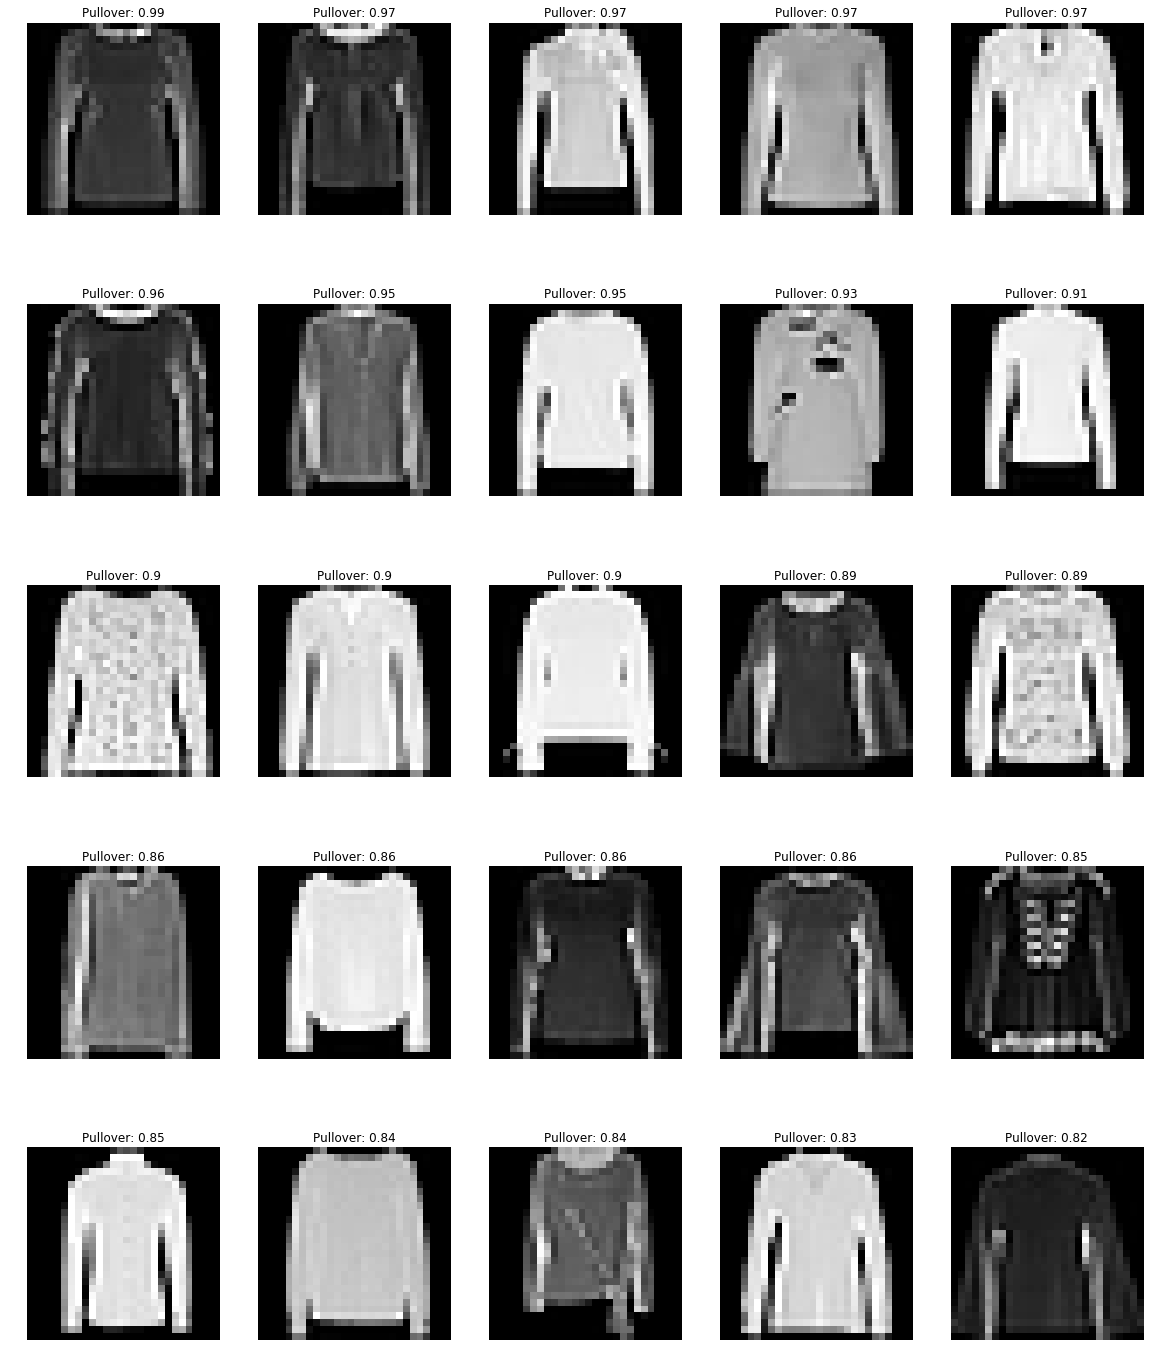

In [135]:
plot_df_examples(fp)

### Confusion Matrix

In [136]:
from image_processing_workshop.visual import plot_coocurance_matrix

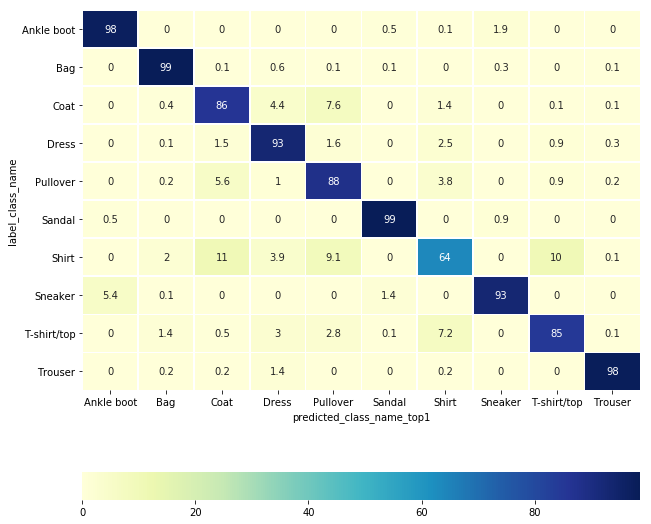

In [137]:
plot_coocurance_matrix(df, use_log=False)